<a href="https://colab.research.google.com/github/nelsonsalgado70/nelson/blob/main/MVG02_3D_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![visioncolab](https://drive.google.com/uc?export=view&id=10UMKqKSnU2grmitxYxvL7V6GVMu8RrpP)


`Google colab's for image processing, pattern recognition and computer vision`

[Nelson Salgado]


# 3D Reconstruction
In this example we estimate the length of an object in millimeters. There are three views $p$, $q$ and $r$. Two points of the object are given by the user in each view. The code estimates the two 3D points and compute the 3D distance between them. Since the calibration of this X-ray computer vision system was implemented using a calibration object with dimensions measured in millimeters, it is clear that that the 3D reconstructed points are given in millimeters as well.

In [1]:
# Load Images from GDxray dataset
!mkdir ~/GDXray
!mkdir ~/GDXray/Baggages

In [2]:
!wget https://www.dropbox.com/s/swysmbjjuhnwpq6/B0044.zip
!unzip -oq B0044.zip  # Force to overwrite facilitates running the notebook without interactive actions
!rm B0044.zip
!rsync -av B0044 ~/GDXray/Baggages/

--2024-03-29 21:27:02--  https://www.dropbox.com/s/swysmbjjuhnwpq6/B0044.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/swysmbjjuhnwpq6/B0044.zip [following]
--2024-03-29 21:27:02--  https://www.dropbox.com/s/raw/swysmbjjuhnwpq6/B0044.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc23088fb77c672f29ef301d6e92.dl.dropboxusercontent.com/cd/0/inline/CQDcShpQBrj66RzFsWbM2HxGhh7I8Oaay6NaBF-O-nam_QV9EkO13dqFP37dWD6X57vc1iFhL8T6pUmzvfRbo5zPeWSyQwMC_2wTMduFvGPoe6mJ5TUhbsnwKeIfbDcHCFg/file# [following]
--2024-03-29 21:27:03--  https://uc23088fb77c672f29ef301d6e92.dl.dropboxusercontent.com/cd/0/inline/CQDcShpQBrj66RzFsWbM2HxGhh7I8Oaay6NaBF-O-nam_QV9EkO13dqFP37dWD6X57vc1iFhL8T6pUmzvfRbo5zPeWSyQwMC_2wTMduFvGPoe6mJ5TUhbsnwKeIfbDcHC

In [3]:
# Load calibrated projection matrices
import scipy.io as sio
#!wget https://www.dropbox.com/s/es2k1qx1v6qle37/Pmatrices.mat
!wget https://www.dropbox.com/s/og4uhv0fo0qxdvn/Pmatrices.mat
data = sio.loadmat('Pmatrices.mat')

--2024-03-29 21:28:21--  https://www.dropbox.com/s/og4uhv0fo0qxdvn/Pmatrices.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/og4uhv0fo0qxdvn/Pmatrices.mat [following]
--2024-03-29 21:28:22--  https://www.dropbox.com/s/raw/og4uhv0fo0qxdvn/Pmatrices.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc814957f4d0700a40190f630828.dl.dropboxusercontent.com/cd/0/inline/CQANJJyJbxt4_HKgK6HwRzd_mFONNoWj2ZSix8yUAzIJc93oy4D3kwrge2zVUt-fzgBk4lbVk69jqTGFXSFdaBQxIfyvFyfSLzZ8wMbXwV500ei4hqydlOdDib5rErAIbuQ/file# [following]
--2024-03-29 21:28:22--  https://uc814957f4d0700a40190f630828.dl.dropboxusercontent.com/cd/0/inline/CQANJJyJbxt4_HKgK6HwRzd_mFONNoWj2ZSix8yUAzIJc93oy4D3kwrge2zVUt-fzgBk4lbVk69jqTGFXSFdaBQxIfyvFyfSLzZ8wMbXwV500ei4hqydlO

In [5]:
# Function extracted from library pyxvis, written by Christian Pieringer, Domingo Mery
def recon_3dn(m, mat_p, method=None):
    """
    This method computes the reconstruction of a M point from two dimensional
    points in images.

    Args:
        m:
        mat_p:
        method:
        ls: the function computes the reconstruction using least-square method

    Returns:
        mat_mr: Reprojected points
        ms: Estimated points in 2D
        err: reprojection error in pixels
    """

    n = m.shape[-1]

    mat_q = np.zeros((2 * n, 3))
    mat_r = np.zeros((2 * n, 1))

    for k in range(n):
        x = m[0, k] / m[2, k]
        y = m[1, k] / m[2, k]
        p = mat_p[k * 3:k * 3 + 3, :]
        mat_q[k * 2:k * 2 + 2, :] = np.array(
            [
                [p[2, 0] * x - p[0, 0], p[2, 1] * x - p[0, 1],
                 p[2, 2] * x - p[0, 2]],
                [p[2, 0] * y - p[1, 0], p[2, 1] * y - p[1, 1],
                 p[2, 2] * y - p[1, 2]]
            ]
        )

        mat_r[k * 2:k * 2 + 2, :] = np.array(
            [
                [p[0, 3] - p[2, 3] * x],
                [p[1, 3] - p[2, 3] * y]
            ]
        )

    mat_mr = np.vstack([np.dot(np.linalg.pinv(mat_q), mat_r), 1.0])  # Compute [Q.T * Q] * Q.T as pseudoinverse

    ms = mat_p @ mat_mr
    ms = np.reshape(ms, (n, 3)).T
    ms = ms / ms[-1, :]
    d = ms[0:1, :] - m[0:1, :]
    err = np.sqrt(np.sum(d * d, 1)).item()

    return mat_mr, ms, err


def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st


Projection Matrices:
P1 =  [[-7.96593955e+03 -1.20081318e+03  5.35587150e+00  1.29786479e+06]
 [-2.15860979e+01 -1.28491171e+03 -7.95823608e+03  1.06426593e+06]
 [-1.43537660e-02 -9.99895554e-01  1.68838178e-03  9.64055869e+02]]
P2 =  [[-2.83078450e+03  7.54220156e+03  5.35587150e+00  1.29786479e+06]
 [-1.26132131e+03 -2.46033776e+02 -7.95823608e+03  1.06426593e+06]
 [-9.81029753e-01 -1.93849874e-01  1.68838178e-03  9.64055869e+02]]
P3 =  [[ 7.91917914e+03  1.47808896e+03  5.35587150e+00  1.29786479e+06]
 [-2.32698237e+01  1.28488232e+03 -7.95823608e+03  1.06426593e+06]
 [-2.05508295e-02  9.99787384e-01  1.68838178e-03  9.64055869e+02]]
Object size: 45.5 mm


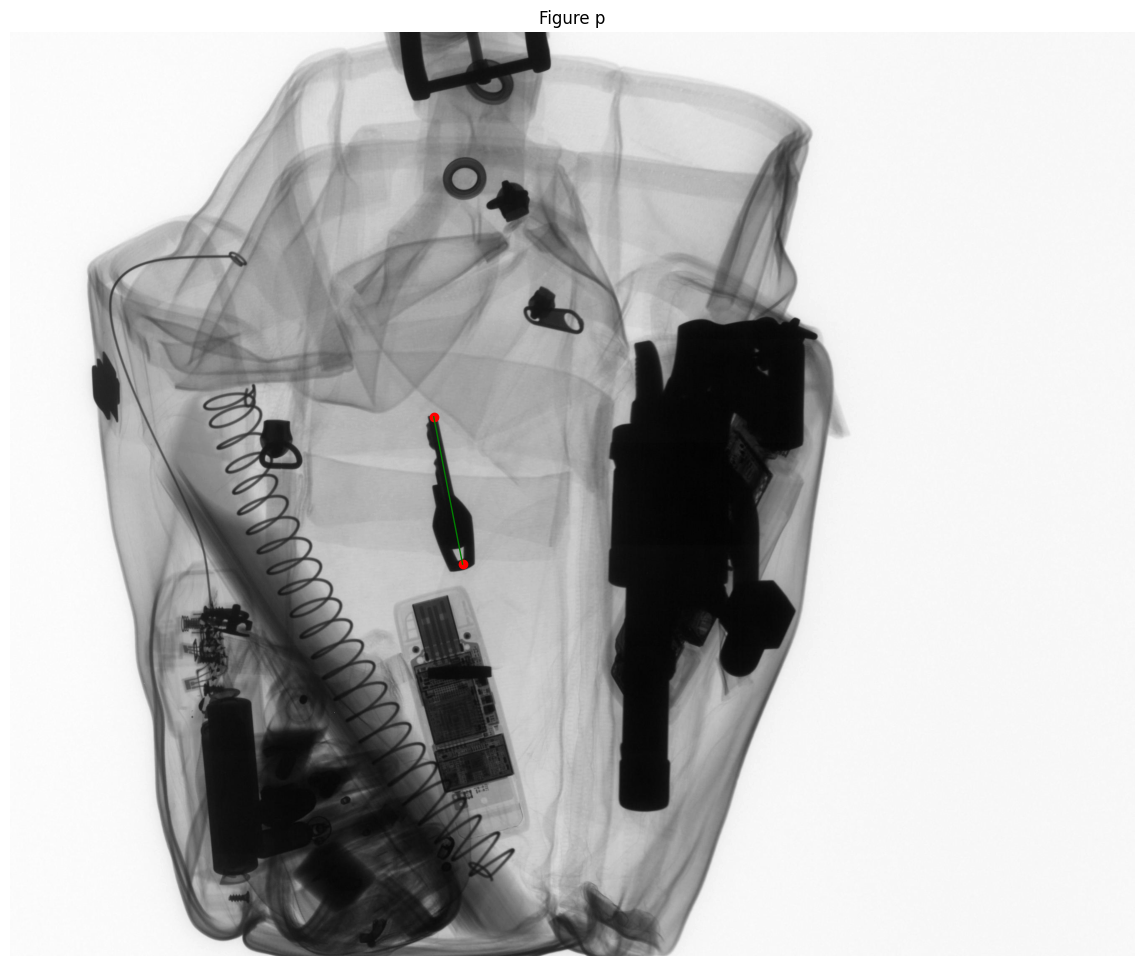

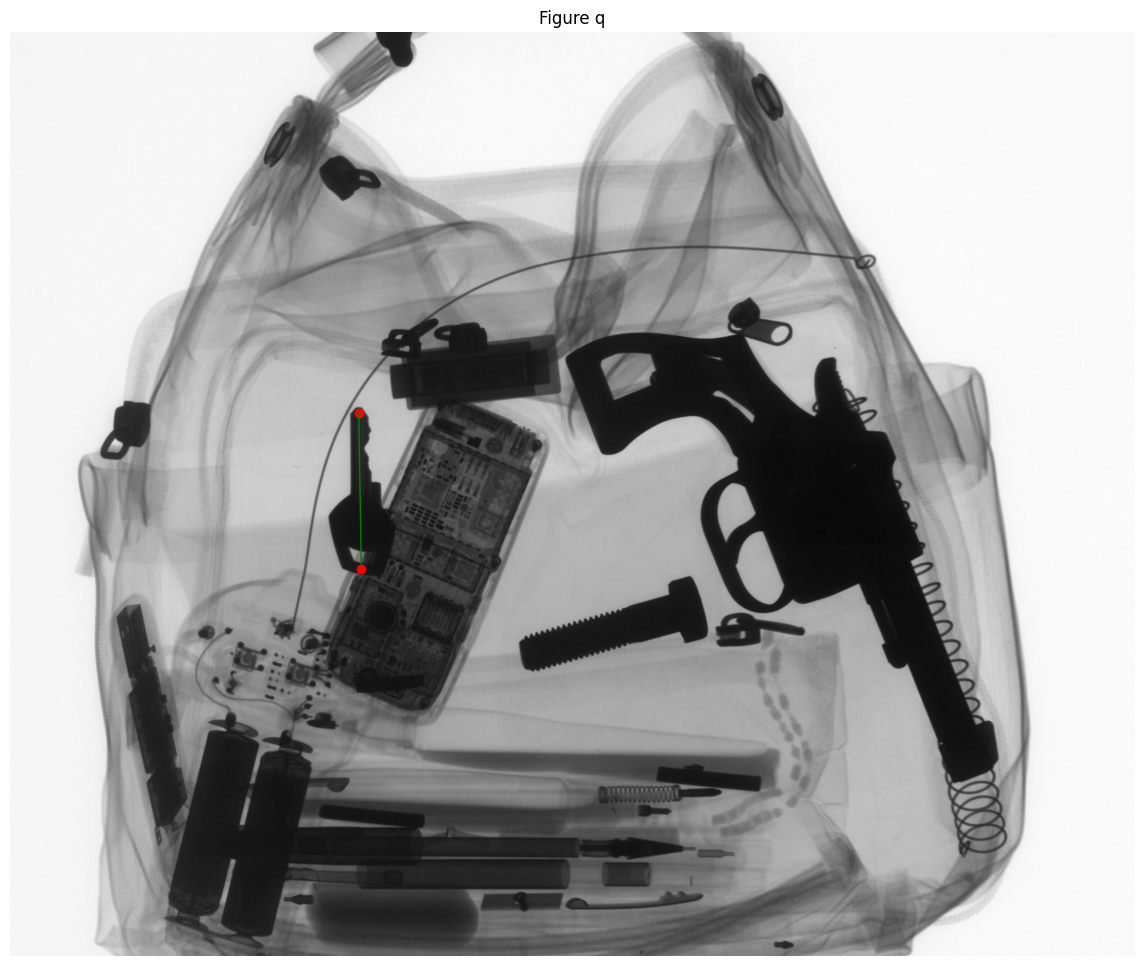

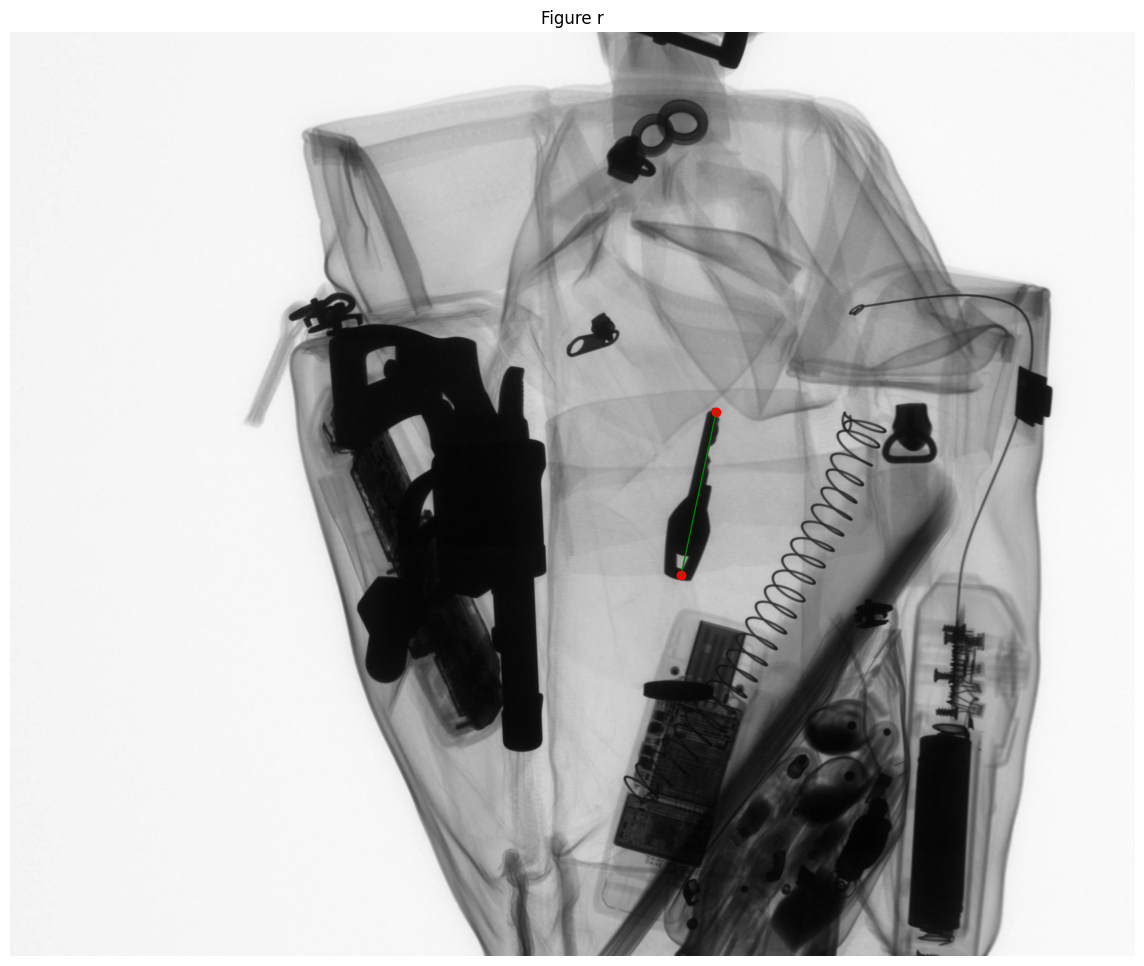

In [6]:
import numpy as np
import matplotlib.pylab as plt
from cv2 import imread, IMREAD_GRAYSCALE


p, q, r = (1, 40, 90)  # indices for p, q and r

# Load projection matrices for views p, q, r
P1 = data['P'][:, :, p]  # Reprojection matrix of view p
P2 = data['P'][:, :, q]  # Reprojection matrix of view q
P3 = data['P'][:, :, r]  # Reprojection matrix of view r

print('Projection Matrices:')
print('P1 = ',P1)
print('P2 = ',P2)
print('P3 = ',P3)


P = np.vstack([P1, P2, P3])  # Join all projection matrices


Ip = imread('B0044/B0044_'+num2fixstr(p,4)+'.png', IMREAD_GRAYSCALE)
Iq = imread('B0044/B0044_'+num2fixstr(q,4)+'.png', IMREAD_GRAYSCALE)
Ir = imread('B0044/B0044_'+num2fixstr(r,4)+'.png', IMREAD_GRAYSCALE)


# Plot lines and plot on figures
fig1, ax1 = plt.subplots(1, 1, subplot_kw=dict(title='Figure p'),figsize=(18,12))
ax1.imshow(Ip, cmap='gray')
ax1.axis('off')

#print('Click first and second points in Figure 1 ...')
#mp = np.hstack([np.array(plt.ginput(2)), np.ones((2, 1))]).T  # Click
mp = np.ones((3,2))
mp[0,0] = 1012
mp[1,0] = 919
mp[0,1] = 1081
mp[1,1] = 1271

ax1.plot(mp[0, :], mp[1, :], 'ro')
ax1.plot(mp[0, :], mp[1, :], 'g', linewidth=1.0)
fig1.canvas.draw()

fig2, ax2 = plt.subplots(1, 1, subplot_kw=dict(title='Figure q'),figsize=(18,12))
ax2.imshow(Iq, cmap='gray')
ax2.axis('off')
#print('Click first and second points in Figure 2 ...')
#mq = np.hstack([np.array(plt.ginput(2)), np.ones((2, 1))]).T  # Click
mq = np.ones((3,2))
mq[0,0] = 833
mq[1,0] = 910
mq[0,1] = 839
mq[1,1] = 1283

ax2.plot(mq[0, :], mq[1, :], 'ro')
ax2.plot(mq[0, :], mq[1, :], 'g', linewidth=1.0)
fig2.canvas.draw()

fig3, ax3 = plt.subplots(1, 1, subplot_kw=dict(title='Figure r'),figsize=(18,12))
ax3.imshow(Ir, cmap='gray')
ax3.axis('off'),
#print('Click first and second points in Figure 3 ...')
#mr = np.hstack([np.array(plt.ginput(2)), np.ones((2, 1))]).T  # Click
mr = np.ones((3,2))
mr[0,0] = 1687
mr[1,0] = 907
mr[0,1] = 1603
mr[1,1] = 1298

ax3.plot(mr[0, :], mr[1, :], 'ro')
ax3.plot(mr[0, :], mr[1, :], 'g', linewidth=1.0)
fig3.canvas.draw()

# 3D reprojection
mm_1 = np.vstack([mp[:, 0], mq[:, 0], mr[:, 0]]).T  # First 2D point in each view
mm_2 = np.vstack([mp[:, 1], mq[:, 1], mr[:, 1]]).T  # Second 2D point in each view
M1, d1, err1 = recon_3dn(mm_1, P)  # 3D reconstruction of first point
M2, d2, err2 = recon_3dn(mm_2, P)  # 3D reconstruction of second point

Md = M1.ravel()[:-1] - M2.ravel()[:-1]  # 3D vector from 1stt to 2nd point
dist = np.linalg.norm(Md)  # length of 3D vector in mm

print(f'Object size: {dist:0.3} mm')

plt.show()


The output of this code is shown in the last three figures. The code uses the function of PyXvis: `reco_3dn` to compute the 3D reconstruction using:

$
{\bf \hat M} = [{\bf Q}^{\sf T} {\bf Q}]^{-1}{\bf Q}^{\sf T}{\bf r}.
$

The estimated length in this example was `dist = 45.5mm`. The reader that is interested in 3D reconstruction using equation:

$
{\bf M = H}^{-1}{\bf M'} = \alpha {\bf H}^{-1}
\left[\begin{array}{c}
(y_q b_{14} - x_q b_{24}){\bf m}_p\\
(x_q {\bf b}_2  - y_q {\bf b}_1 ){\bf m}_p\end{array} \right]
$

for two views can use command `reco_3d2` from PyXvis. More details in Section 3.6 of the Book.